In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(10,6)})

import plotly.offline as py
py.init_notebook_mode(connected=True) # connected=True means it will download the latest version of plotly javascript library.
import plotly.graph_objs as go

import plotly.figure_factory as ff
import cufflinks as cf

import warnings
warnings.filterwarnings('ignore')

### Data Cleaning

In [2]:
df = pd.read_csv('googleplaystore.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
print('Total count of Apps(Duplicates):', df.shape[0])
df.drop_duplicates(subset='App', inplace=True)
print('Total count of Apps(No Duplicates):', df.shape[0])

Total count of Apps(Duplicates): 10841
Total count of Apps(No Duplicates): 9660


In [4]:
print(df.Category.unique())
print(df.Rating.unique())
print(df.Size.unique())
print(df.Installs.unique())
print(df.Type.unique())
print(df.Price.unique())
print(df['Android Ver'].unique())

['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION' '1.9']
[ 4.1  3.9  4.7  4.5  4.3  4.4  3.8  4.2  4.6  3.2  4.   nan  4.8  4.9
  3.6  3.7  3.3  3.4  3.5  3.1  5.   2.6  3.   1.9  2.5  2.8  2.7  1.
  2.9  2.3  2.2  1.7  2.   1.8  2.4  1.6  2.1  1.4  1.5  1.2 19. ]
['19M' '14M' '8.7M' '25M' '2.8M' '5.6M' '29M' '33M' '3.1M' '28M' '12M'
 '20M' '21M' '37M' '2.7M' '5.5M' '17M' '39M' '31M' '4.2M' '7.0M' '23M'
 '6.0M' '6.1M' '4.6M' '9.2M' '5.2M' '11M' '24M' 'Varies with device'
 '9.4M' '15M' '10M' '1.2M' '26M' '8.0M' '7.9M' '56M' '57M' '35M' '54M'
 '201k' '3.6M' '5.7M' '8.6M' '2.4M' '2

In [5]:
# There is an odd entry in Category column.
# We replace it with 'LIFESTYLE' which seems to be a reasonable category for that app. 
df['Category'].replace('1.9', 'LIFESTYLE', inplace=True)

# There is an unusual rating 19 which we assume and replace with 1.9
df['Rating'].replace(19, 1.9, inplace=True)

# df[df['Size'] == 'Varies with device'].shape
# There are 1227 entries named 'Varies with device' in Size column. Removing all of them is not a good idea.
df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)

# There is 1 entry named 'Paid' in Installs column which does not make any sense so we remove that column.
df = df[df['Installs'] != 'Paid']

# df.Type.value_counts()
# Type column can have either 'Free' or 'Paid'. We remove 1 entry '0' which is odd.
df = df[df['Type'] != '0']

# df[df['Price'] == 'Everyone']
df = df[df['Price'] != 'Everyone']

# df['Android Ver'].value_counts()
# 990 NaN's 
df.loc[df['Android Ver'] == 'Varies with device','Android Ver'] = np.NaN

### Data preprocessing
 - Remove '+' and ',' from 'Number of Installs' to make it numeric
 - Convert all app sizes to MB
 - Remove '$' from Price 
 - Convert all review text to English language using Google Translator library

In [6]:
# Installs : Remove + and ,
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
df['Installs'] = df['Installs'].astype(float)
#print(type(df['Installs'].values))

# Size : Remove 'M', Replace 'k' and divide by 1000
#df['Size'] = df['Size'].fillna(0)
df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: str(x).replace(',', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)
df['Size'] = df['Size'].astype(float)

# Price
df['Price'] = df['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
df['Price'] = df['Price'].astype(float)

# Reviews
df['Reviews'] = df['Reviews'].astype(float)

### Android market breakdown
Which category has the highest share of apps in the market?

In [7]:
number_of_apps_in_category = df['Category'].value_counts().sort_values(ascending=True)

fig = {
    'data': [{'labels': number_of_apps_in_category.index,
              'values': number_of_apps_in_category.values,
              'type': 'pie',
              'hoverinfo': 'label+value'}],
    'layout': {'title': 'Category Segmentation'}
     }

py.iplot(fig, filename='active_category')

- **Family** and **Game** apps have the highest market prevelance. 
- Interestingly, **Tools, Business and Medical** apps are also catching up.

### Average rating of apps
Do any apps perform really good or really bad?

In [8]:
data = [go.Histogram(
        x = df.Rating,
        xbins = {'start': 1, 'size': 0.1, 'end' :5})]

print('Average app rating = ', np.mean(df['Rating']))
py.iplot(data, filename='overall_rating_distribution')

Average app rating =  4.173243045387998


Generally, most apps do well with an average rating of **4.17**.

Let's break this down and inspect if we have categories which perform exceptionally good or bad.

### Best performing categories

In [9]:
groups = df.groupby('Category').filter(lambda x: len(x) >= 170).reset_index()
#print(type(groups.item.['BUSINESS']))
print('Average rating = ', np.nanmean(list(groups.Rating)))
#print(len(groups.loc[df.Category == 'DATING']))
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 720, len(set(groups.Category)))]


#df_sorted = df.groupby('Category').agg({'Rating':'median'}).reset_index().sort_values(by='Rating', ascending=False)
#print(df_sorted)

layout = {'title' : 'App ratings across major categories',
          'xaxis': {'tickangle':-40},
          'yaxis': {'title': 'Rating'},
          'plot_bgcolor': 'rgb(250,250,250)',
          'shapes': [{
              'type' :'line',
              'x0': -.5,
              'y0': np.nanmean(list(groups.Rating)),
              'x1': 19,
              'y1': np.nanmean(list(groups.Rating)),
              'line': { 'dash': 'dashdot'}
          }]
          }

data = [{
    'y': df.loc[df.Category==category]['Rating'], 
    'type':'violin',
    'name' : category,
    'showlegend':False,
    #'marker': {'color': 'Set2'},
    } for i,category in enumerate(list(set(groups.Category)))]



py.iplot({'data': data, 'layout': layout})

Average rating =  4.170026786973072



- Almost all app categories perform decently. **Health and Fitness** and **Books and Reference** produce the highest quality apps with **50% apps having a rating greater than 4.5.** This is extremely high!


- On the contrary, **50% of apps in the Dating category have a rating lesser than the average rating**. 


- A few **junk apps** also exist in the **Lifestyle**, **Family** and **Finance** category.


### Sizing Strategy - Light Vs Bulky?

How do app sizes impact the app rating?

In [10]:
groups = df.groupby('Category').filter(lambda x: len(x) >= 50).reset_index()

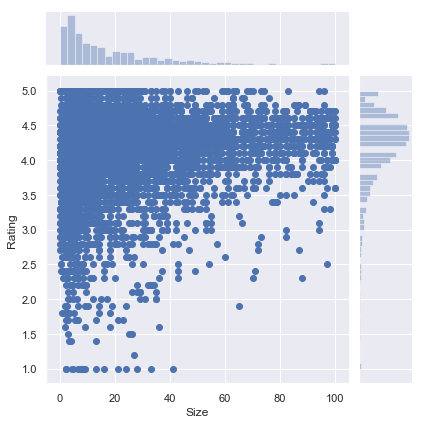

In [11]:
# sns.set_style('ticks')
# fig, ax = plt.subplots()
# fig.set_size_inches(8, 8)
sns.set_style("darkgrid")
ax = sns.jointplot(df['Size'], df['Rating'])
#ax.set_title('Rating Vs Size')

Most top rated apps are optimally sized between **~2MB to ~40MB** - neither too light nor too heavy.

In [12]:
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(list(set(groups.Category))))]

subset_df = df[df.Size > 40]
groups_temp = subset_df.groupby('Category').filter(lambda x: len(x) >20)

# for category in enumerate(list(set(groups_temp.Category))):
#     print (category)

data = [{
    'x': groups_temp.loc[subset_df.Category==category[1]]['Rating'], 
    'type':'scatter',
    'y' : subset_df['Size'],
    'name' : str(category[1]),
    'mode' : 'markers',
    'showlegend': True,
    #'marker': {'color':c[i]}
    #'text' : df['rating'],
    } for category in enumerate(['GAME', 'FAMILY'])]


layout = {'title':"Rating vs Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

py.iplot({'data': data, 'layout': layout})

Most bulky apps ( >50MB) belong to the **Game** and **Family** category. Despite this, these bulky apps are fairly highly rated indicating that they are bulky for a purpose.

### Pricing Strategy - Free Vs Paid?
How do app prices impact app rating?

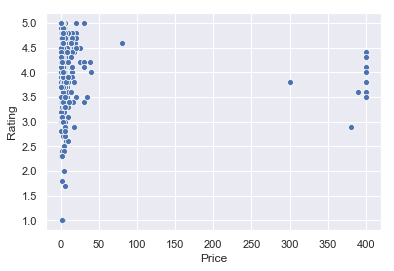

In [13]:
paid_apps = df[df.Price>0]
p = sns.scatterplot(x = "Price", y = "Rating", data=paid_apps)

Most of the apps cost less than 20 dollars.
Very few of the paid apps have low ratings.
Most of the top rated apps are priced between 1 and 25 dollars.


### Current pricing trend - How to price your app?

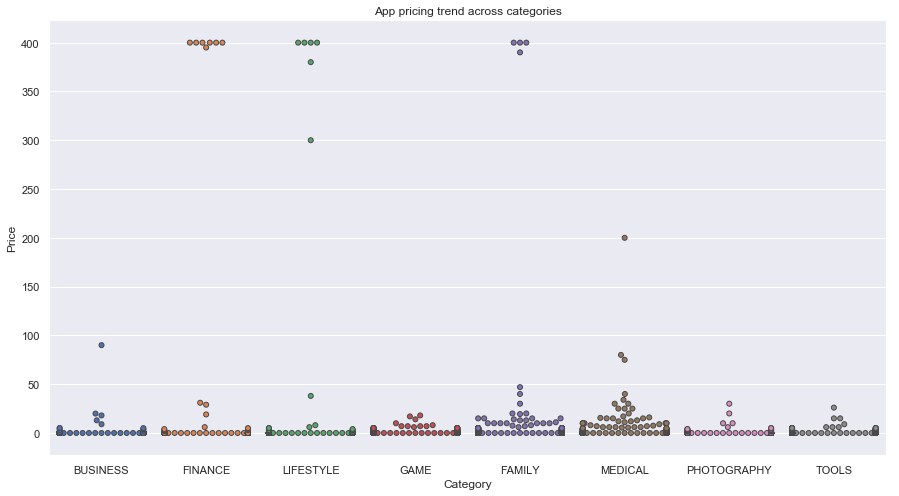

In [14]:
subset_df = df[df.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY', 'MEDICAL', 'TOOLS', 'FINANCE',
                                 'LIFESTYLE','BUSINESS'])]
sns.set_style('darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
p = sns.swarmplot(x="Category", y="Price", data=subset_df, linewidth=1)
title = ax.set_title('App pricing trend across categories')

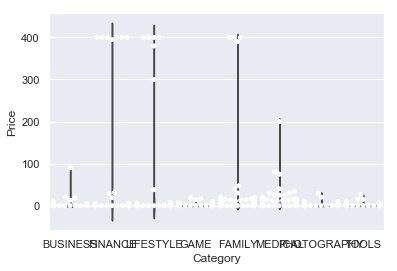

In [15]:
ax = sns.violinplot(x="Category", y="Price", data=subset_df, inner=None)
ax = sns.swarmplot(x="Category", y="Price", data=subset_df,
                    color="white", edgecolor="gray")

**Shocking...Apps priced above 250\$ !!! ** Let's quickly examine what these junk apps are.

In [16]:
#print('Junk apps priced above 350$')
df[['Category', 'App']][df.Price > 200]

,Category,App
4197,FAMILY,most expensive app (H)
4362,LIFESTYLE,💎 I'm rich
4367,LIFESTYLE,I'm Rich - Trump Edition
5351,LIFESTYLE,I am rich
5354,FAMILY,I am Rich Plus
5355,LIFESTYLE,I am rich VIP
5356,FINANCE,I Am Rich Premium
5357,LIFESTYLE,I am extremely Rich
5358,FINANCE,I am Rich!
5359,FINANCE,I am rich(premium)


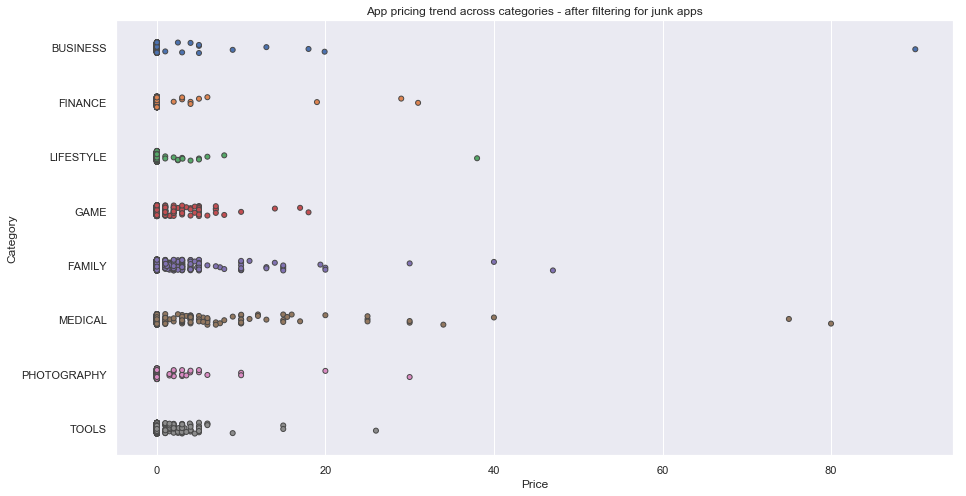

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
subset_df_price = subset_df[subset_df.Price<100]
p = sns.stripplot(x="Price", y="Category", data=subset_df_price, jitter=True, linewidth=1)
title = ax.set_title('App pricing trend across categories - after filtering for junk apps')

- Clearly, **Medical and Family apps** are the most expensive. Some medical apps extend even upto 80\$.


- All other apps are priced under 30\$.


- Surprisingly, **all game apps are reasonably priced below 20\$.**

### Distribution of paid and free apps across categories

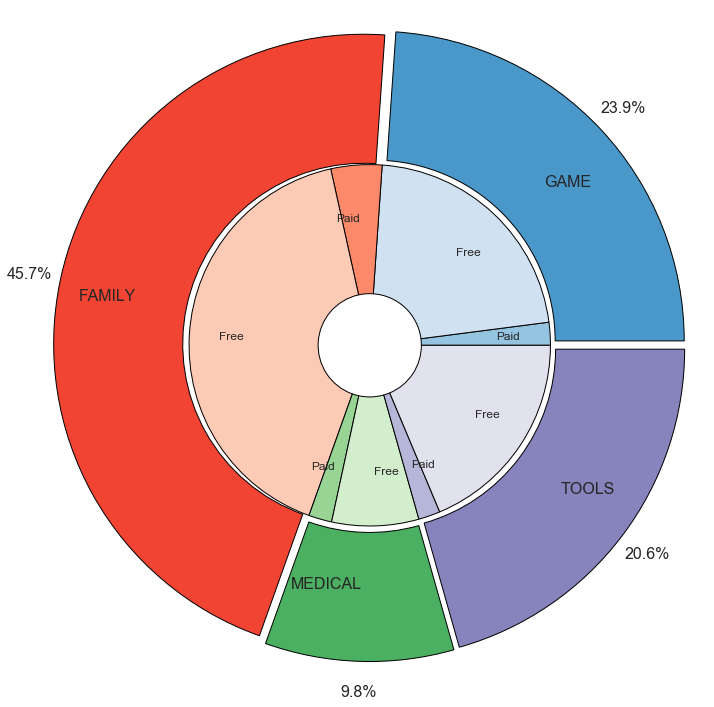

In [18]:
# Stacked bar graph for top 5-10 categories - Ratio of paid and free apps
#fig, ax = plt.subplots(figsize=(15,10))

new_df = df.groupby(['Category', 'Type']).agg({'App' : 'count'}).reset_index()
#print(new_df)

# outer_group_names = df['Category'].sort_values().value_counts()[:5].index
# outer_group_values = df['Category'].sort_values().value_counts()[:5].values

outer_group_names = ['GAME', 'FAMILY', 'MEDICAL', 'TOOLS']
outer_group_values = [len(df.App[df.Category == category]) for category in outer_group_names]

a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]


inner_group_names = ['Paid', 'Free'] * 4
inner_group_values = []
#inner_colors = ['#58a27c','#FFD433']


for category in outer_group_names:
    for t in ['Paid', 'Free']:
        x = new_df[new_df.Category == category]
        try:
            #print(x.App[x.Type == t].values[0])
            inner_group_values.append(int(x.App[x.Type == t].values[0]))
        except:
            #print(x.App[x.Type == t].values[0])
            inner_group_values.append(0)

explode = (0.025,0.025,0.025,0.025)
# First Ring (outside)
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')
mypie, texts, _ = ax.pie(outer_group_values, radius=1.2, labels=outer_group_names, autopct='%1.1f%%', pctdistance=1.1,
                                 labeldistance= 0.75,  explode = explode, colors=[a(0.6), b(0.6), c(0.6), d(0.6)], textprops={'fontsize': 16})
plt.setp( mypie, width=0.5, edgecolor='black')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(inner_group_values, radius=1.2-0.5, labels=inner_group_names, labeldistance= 0.7, 
                   textprops={'fontsize': 12}, colors = [a(0.4), a(0.2), b(0.4), b(0.2), c(0.4), c(0.2), d(0.4), d(0.2)])
plt.setp( mypie2, width=0.5, edgecolor='black')
plt.margins(0,0)
 
# show it
plt.tight_layout()
plt.show()

                    Distribution of free and paid apps across major categories

### Are paid apps downloaded as much as free apps?

In [19]:
trace0 = go.Box(
    y=np.log10(df['Installs'][df.Type=='Paid']),
    name = 'Paid',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)

trace1 = go.Box(
    y=np.log10(df['Installs'][df.Type=='Free']),
    name = 'Free',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)

layout = go.Layout(
    title = "Number of downloads of paid apps Vs free apps",
    yaxis= {'title': 'Number of downloads (log-scaled)'}
)

data = [trace0, trace1]
py.iplot({'data': data, 'layout': layout})

**Paid apps have a relatively lower number of downloads than free apps.** However, it is not too bad.

### How do the sizes of paid apps and free apps vary?

In [20]:
temp_df = df[df.Type == 'Paid']
temp_df = temp_df[temp_df.Size > 5]
#type_groups = df.groupby('Type')

data = [{
    #'x': type_groups.get_group(t)['Rating'], 
    'x' : temp_df['Rating'],
    'type':'scatter',
    'y' : temp_df['Size'],
    #'name' : t,
    'mode' : 'markers',
    #'showlegend': True,
    'text' : df['Size'],
    } for t in set(temp_df.Type)]


layout = {'title':"Rating vs Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

py.iplot({'data': data, 'layout': layout})

In [21]:
#temp_df = df[df.Type == 'Paid']
#temp_df = temp_df[temp_df.Size > 5]
type_groups = df.groupby('Type')

data = [{
    #'x': type_groups.get_group(t)['Rating'], 
    'x' : temp_df['Rating'],
    'type':'scatter',
    'y' : temp_df['Size'],
    #'name' : t,
    'mode' : 'markers',
    #'showlegend': True,
    'text' : df['Size'],
    } for t in set(temp_df.Type)]


layout = {'title':"Rating vs Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

py.iplot({'data': data, 'layout': layout})

- **Majority of the paid apps that are highly rated have small sizes.** This means that most paid apps are designed and developed to cater to specific functionalities and hence are not bulky.


- **Users prefer to pay for apps that are light-weighted.** A paid app that is bulky may not perform well in the market.

# CONCLUSION

 - Average rating of (active) apps on Google Play Store is **4.17**.
 
 
 - **Users prefer to pay for apps that are light-weighted.** Thus, a paid app that is bulky may not perform well in the market.
 
 
 - Most of the top rated apps are **optimally sized between ~2MB to ~40MB** - neither too light nor too heavy.
 
 
 - Most of the top rated apps are **optimally priced between ~1\$ to ~30\$** - neither too cheap nor too expensive.
 
 
 - **Medical and Family apps are the most expensive** and even extend upto 80\$.
 
 
 - Users tend to download a given app more if it has been reviewed by a large number of people.
 
 
 - **Health and Fitness** apps receive more than **85% positive reviews**. **Game and Social** apps receive mixed feedback - **50% positive and 50% negative.**
 
 
 - **Users are more grim and harsh while reviewing free apps** than paid apps. 